In [12]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
def plot_image(image, title):
    fig, ax = plt.subplots()
    im = ax.imshow(image, cmap='gray')
    fig.colorbar(im, ax=ax)
    plt.title(title)
    plt.show()

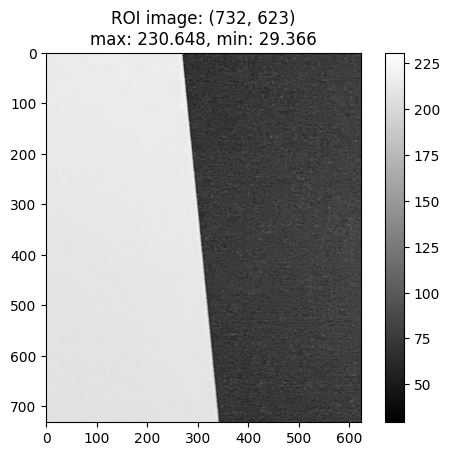

In [14]:
# load ROI sample
sample = np.load(r"..\quickMTF\sample_vert_edge.npy")
# sample = np.load(r"..\quickMTF\sample.npy")

plot_image(sample, f"ROI image: {sample.shape}\nmax: {sample.max():0.3f}, min: {sample.min():0.3f}")

In [15]:
# SFR settings
s_super_sampling = 4
s_mtf_index = 0.5

s_diff_kernel = np.array([0.5, 0, -0.5])
s_diff_offset = 0.0
s_diff_ft = 2

s_conv_kernel = 3,
s_win_width = 5

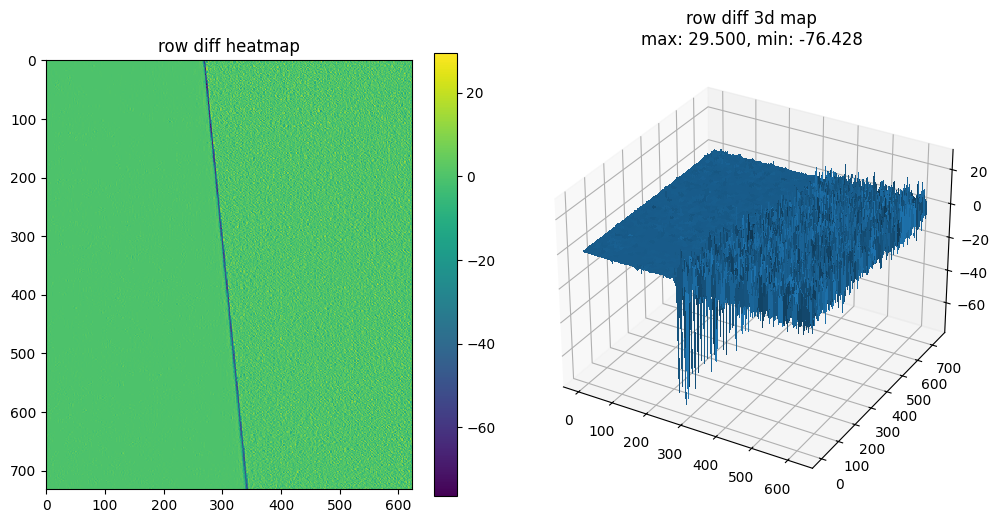

In [16]:
# calculate diff
def differentiate(arr, kernel):
    if len(arr.shape) == 2:
        # Use 2-d convolution, but with a one-dimensional (row-oriented) kernel
        out = scipy.signal.convolve2d(arr, [kernel], 'same', 'symm')
    else:
        # Input is a one-dimensional array
        out = scipy.signal.convolve2d(arr.reshape(1, arr.shape[0]), [kernel], 'same', 'symm')
        out = out.reshape(out.shape[1],)
    return out

diff = differentiate(sample, s_diff_kernel)

def plot_diff(diff):
    fig = plt.figure(figsize=(10, 5))
    ax00 = fig.add_subplot(1, 2, 1)
    im00 = ax00.imshow(diff, cmap="viridis", interpolation="nearest")
    fig.colorbar(im00)
    ax00.set_title("row diff heatmap")

    ax01 = fig.add_subplot(1, 2, 2, projection="3d")
    X = np.arange(0, diff.shape[1])
    Y = np.arange(0, diff.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = diff
    surf = ax01.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
    ax01.set_title(f"row diff 3d map\nmax: {diff.max():0.3f}, min: {diff.min():0.3f}")
    plt.tight_layout()
    plt.show()

plot_diff(diff)

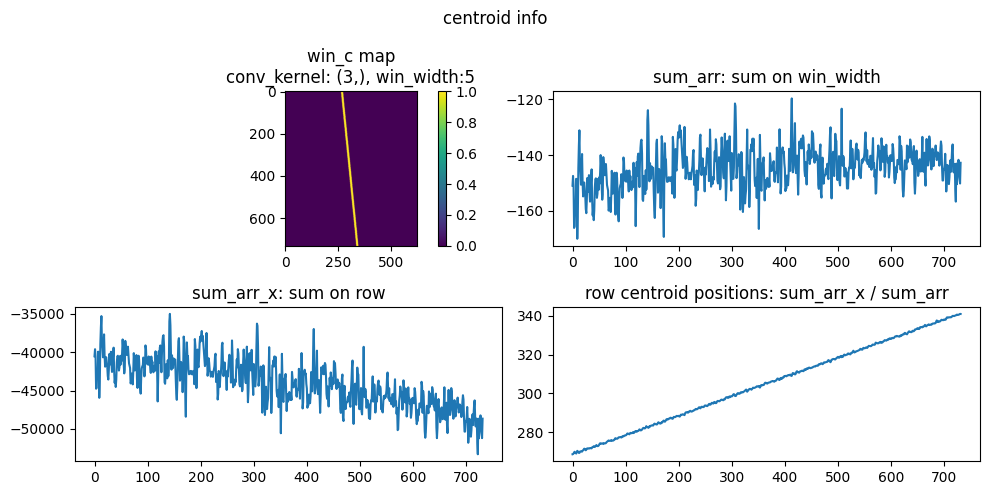

In [17]:
# calculate centroid
def centroid(diff, conv_kernel, win_width):
    height, width = diff.shape

    win = np.zeros(diff.shape)
    for i in range(height):
        win_c = np.argmax(np.abs(np.convolve(diff[i, :], np.ones(conv_kernel), 'same')))
        win[i, win_c - win_width:win_c + win_width] = 1.0
    x, _ = np.meshgrid(np.arange(width), np.arange(height))
    sum_arr = np.sum(diff * win, axis=1)
    sum_arr_x = np.sum(diff * win * x, axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        centr = sum_arr_x / sum_arr

    return centr, conv_kernel, win, win_width, sum_arr, sum_arr_x

centr, conv_kernel, win, win_width, sum_arr, sum_arr_x = centroid(diff, s_conv_kernel, s_win_width)

def plot_centroid_info(centr, conv_kernel, win, win_width, sum_arr, sum_arr_x):
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(2, 2, 1)
    im1 = ax1.imshow(win)
    fig.colorbar(im1)
    ax1.set_title(f"win_c map\nconv_kernel: {conv_kernel}, win_width:{win_width}")

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(sum_arr)
    ax2.set_title("sum_arr: sum on win_width")

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(sum_arr_x)
    ax3.set_title("sum_arr_x: sum on row")

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(centr)
    ax4.set_title("row centroid positions: sum_arr_x / sum_arr")

    plt.suptitle("centroid info")
    plt.tight_layout()
    plt.show()

plot_centroid_info(centr, conv_kernel, win, win_width, sum_arr, sum_arr_x)

centroid shape: (732,)
patch shape: (732, 623)
poly coeffs: [-1.61429291e-06  1.00707449e-01  2.68423695e+02]
slope: 0.0995274007572686
angle: 5.6837820413377145


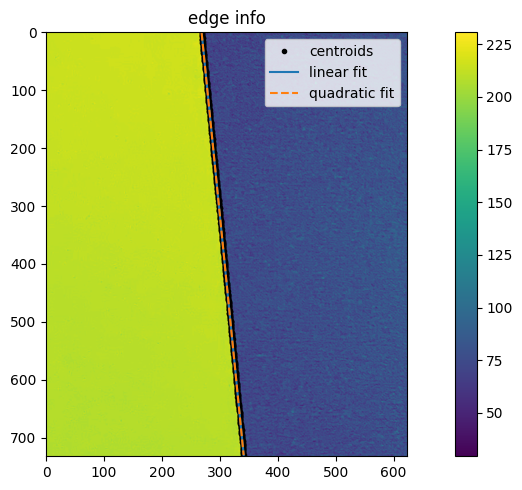

In [18]:
# calculate edge
def angle_from_slope(slope: float):
    return np.rad2deg(np.arctan(slope))

def slope_from_angle(angle: float):
    return np.tan(np.deg2rad(angle))

def calculate_edge(centr, patch_shape, angle=None):

    idx = np.where(np.isfinite(centr))[0][1:-1]
    if angle is None:
        slope, offset = np.polyfit(idx, centr[idx], 1)
    else:
        slope = slope_from_angle(angle)
        offset = np.polyfit(idx, centr[idx] - slope * idx, 0)
    pcoefs = np.polyfit(idx, centr[idx], 2)
    angle = angle_from_slope(slope)

    return pcoefs, idx, slope, offset, angle, patch_shape, centr

pcoefs, idx, slope, offset, angle, patch_shape, centr = calculate_edge(centr, sample.shape)

print(f"centroid shape: {centr.shape}")
print(f"patch shape: {patch_shape}")
print(f"poly coeffs: {pcoefs}")
print(f"slope: {slope}")
print(f"angle: {angle}")

def plot_edge_info(sample, pcoefs, idx, slope, offset, angle, patch_shape, centr):
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(1, 1, 1)
    im1 = ax1.imshow(sample)
    plt.colorbar(im1)
    # ax1.plot(idx, np.polyval(pcoefs, idx))
    ax1.plot(centr[idx], idx, '.k', label="centroids")
    ax1.plot(np.polyval([slope, offset], idx), idx, '-', label="linear fit")
    ax1.plot(np.polyval(pcoefs, idx), idx, '--', label="quadratic fit")
    ax1.set_xlim([0, patch_shape[1]])
    ax1.set_ylim([0, patch_shape[0]])
    ax1.legend(loc='best')
    ax1.invert_yaxis()
    ax1.set_title("edge info")
    
    # plt.suptitle("edge info")
    plt.tight_layout()
    plt.show()

plot_edge_info(sample, pcoefs, idx, slope, offset, angle, patch_shape, centr)

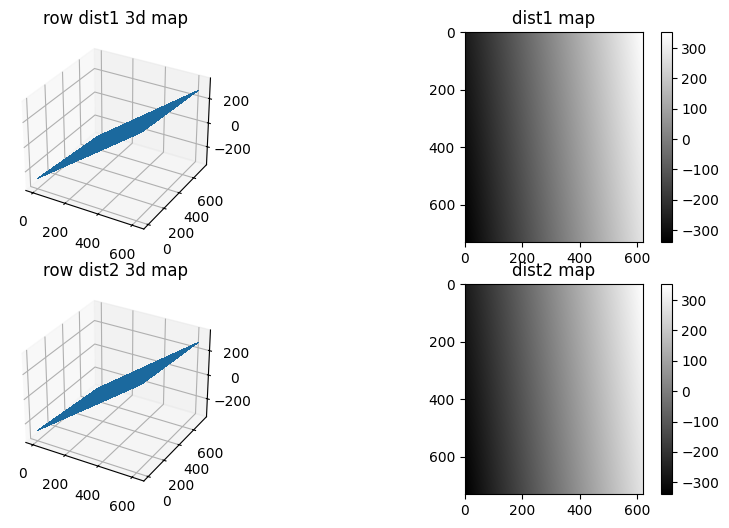

In [19]:
# calculate distance
def cubic_solver(a, b, c, d):
    # Solve the equation a*x**3 + b*x**2 + c*x + d = 0 for a
    # real-valued root x by Cardano's method
    # (https://en.wikipedia.org/wiki/Cubic_equation#Cardano's_formula)

    p = (3 * a * c - b ** 2) / (3 * a ** 2)
    q = (2 * b ** 3 - 9 * a * b * c + 27 * a ** 2 * d) / (27 * a ** 3)

    # A real root exists if 4 * p**3 + 27 * q**2 > 0
    sr = np.sqrt(q ** 2 / 4 + p ** 3 / 27)
    t = np.cbrt(-q / 2 + sr) + np.cbrt(-q / 2 - sr)
    x = t - b / (3 * a)
    return x

def dot(a, b):
    return a[0] * b[0] + a[1] * b[1]

def calc_distance(data_shape, p, quadratic_fit=False, verbose=False):
    # Calculate the distance (with sign) from each point (x, y) in the
    # image patch "data" to the slanted edge described by the polynomial p.
    # It is assumed that the edge is approximately vertically orientated
    # (between -45° and 45° from the vertical direction).
    # Distances to points to the left of the edge are negative, and positive
    # to points to the right of the edge.
    x, y = np.meshgrid(range(data_shape[1]), range(data_shape[0]))

    #verbose and print(f'quadratic fit: {str(quadratic_fit):s}')

    if not quadratic_fit or p[0] == 0.0:
        slope, offset = p[1], p[2]  # use linear fit to edge
        a, b, c = 1, -slope, -offset
        a_b = np.sqrt(a ** 2 + b ** 2)

        # |ax+by+c| / |a_b| is the distance from (x,y) to the slanted edge:
        dist = (a * x + b * y + c) / a_b
    else:
        # Define a cubic polynomial equation for the y-coordinate
        # y0 at the point (x0, y0) on the curved edge that is closest to (x, y)
        d = -y + p[1] * p[2] - x * p[1]
        c = 1 + p[1] ** 2 + 2 * p[2] * p[0] - 2 * x * p[0]
        b = 3 * p[1] * p[0]
        a = 2 * p[0] ** 2

        if p[0] == 0.0:
            y0 = -d / c  # solution if edge is straight (quadratic term is zero)
        else:
            y0 = cubic_solver(a, b, c, d)  # edge is curved

        x0 = p[0] * y0 ** 2 + p[1] * y0 + p[2]
        dxx_dyy = np.array(2 * p[0] * y0 + p[1])  # slope at (x0, y0)
        r2 = dot([1, -dxx_dyy], [1, -dxx_dyy])
        # distance between (x, y) and (x0, y0) along normal to curve at (x0, y0)
        dist = dot([x - x0, y - y0], [1, -dxx_dyy]) / np.sqrt(r2)
    return dist   

dist2 = calc_distance(sample.shape, pcoefs, quadratic_fit=True)
dist1 = calc_distance(sample.shape, [0.0, slope, offset], quadratic_fit=False)

def plot_dist_info(dist1, dist2):
    fig = plt.figure(figsize=(10, 6))
    
    ax00 = fig.add_subplot(2, 2, 1, projection="3d")
    X = np.arange(0, dist1.shape[1])
    Y = np.arange(0, dist1.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = dist1
    surf = ax00.plot_surface(X, Y, Z,
                           linewidth=0, antialiased=False)
    ax00.set_title("row dist1 3d map")
    
    ax01 = fig.add_subplot(2, 2, 2)
    ax01.set_title("dist1 map")
    im0 = ax01.imshow(dist1, cmap="gray")
    fig.colorbar(im0)

    ax10 = fig.add_subplot(2, 2, 3, projection="3d")
    X = np.arange(0, dist2.shape[1])
    Y = np.arange(0, dist2.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = dist2
    surf = ax10.plot_surface(X, Y, Z,
                           linewidth=0, antialiased=False)
    ax10.set_title("row dist2 3d map")
    
    ax11 = fig.add_subplot(2, 2, 4)
    ax11.set_title("dist2 map")
    im2 = ax11.imshow(dist2, cmap="gray")
    fig.colorbar(im2)

    # plt.tight_layout()
    plt.show()

plot_dist_info(dist1, dist2)

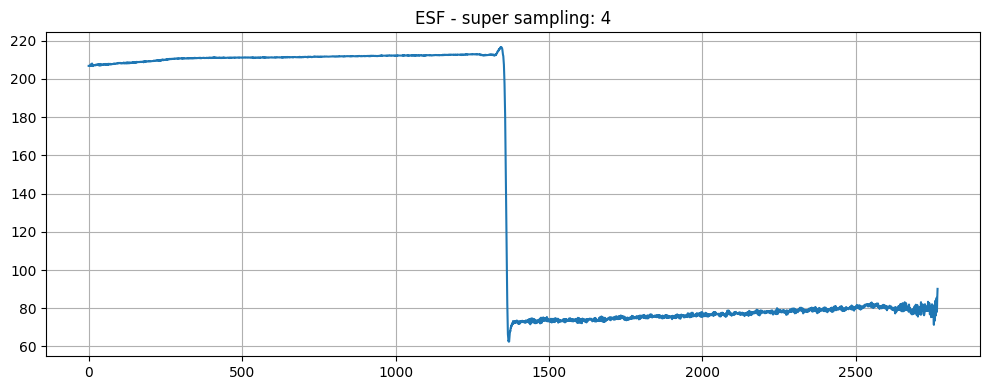

In [20]:
# calculate ESF
def project_and_bin(data, dist, oversampling, verbose=True):
    bins = np.round(dist * oversampling).astype(int)
    bins = bins.flatten()
    bins -= np.min(bins)  # add an offset so that bins start at 0
    if np.max(bins) <=4 or np.max(bins) >=10000 :
        return False
    esf = np.zeros(np.max(bins) + 1)  # Edge spread function
    cnts = np.zeros(np.max(bins) + 1).astype(int)
    data_flat = data.flatten()
    for b_indx, b_sorted in zip(np.argsort(bins), np.sort(bins)):
        esf[b_sorted] += data_flat[b_indx]  # Collect pixel contributions in this bin
        cnts[b_sorted] += 1  # Keep a tab of how many contributions were made to this bin
    # Calculate mean by dividing by the number of contributing pixels. Avoid
    # division by zero, in case there are bins with no content.
    esf[cnts > 0] /= cnts[cnts > 0]
    if np.any(cnts == 0):
        if verbose:
            print("Warning: esf bins with zero pixel contributions were found. Results may be inaccurate.")
            print(f"Try reducing the oversampling factor, which currently is {oversampling:d}.")
        # Try to save the situation by patching in values in the empty bins if possible
        patch_cntr = 0
        for i in np.where(cnts == 0)[0]:  # loop through all empty bin locations
            j = [i - 1, i + 1]  # indices of nearest neighbors
            if j[0] < 0:  # Is left neighbor index outside esf array?
                j = j[1]
            elif j[1] == len(cnts):  # Is right neighbor index outside esf array?
                j = j[0]
            if np.all(cnts[j] > 0):  # Now, if neighbor bins are non-empty
                esf[i] = np.mean(esf[j])  # use the interpolated value
                patch_cntr += 1
        if patch_cntr > 0 and verbose:
            print(f"Values in {patch_cntr:d} empty ESF bins were patched by "
                    f"interpolation between their respective nearest neighbors.")
            # gui.window.log_message(f"Values in {patch_cntr:d} empty ESF bins were patched by "
            #       f"interpolation between their respective nearest neighbors.")
    return esf

esf = project_and_bin(sample, dist1, s_super_sampling)

def plot_esf_info(esf, super_sampling):
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(esf)
    ax.set_title(f"ESF - super sampling: {super_sampling}")
    ax.grid()
    plt.tight_layout()
    plt.show()

plot_esf_info(esf, s_super_sampling)

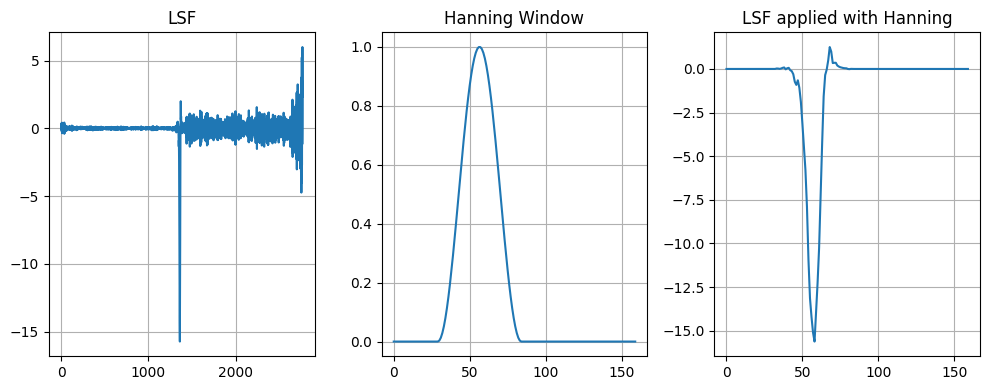

In [21]:
# calculate LSF
def peak_width(y, rel_threshold):
    # Find width of peak in y that is above a certain fraction of the maximum value
    val = np.abs(y)
    val_threshold = rel_threshold * np.max(val)
    indices = np.where(val - val_threshold > 0.0)[0]
    return indices[-1] - indices[0]

def filter_window(lsf, oversampling, lsf_centering_kernel_sz=9,
                    win_width_factor=1.5, lsf_threshold=0.10):
    # The window ('hann_win') returned by this function will be used as a filter
    # on the LSF signal during the MTF calculation to reduce noise

    nn0 = 20 * oversampling  # sample range to be used for the FFT, intial guess
    mid = len(lsf) // 2
    i1 = max(0, mid - nn0)
    i2 = min(2 * mid, mid + nn0)
    nn = (i2 - i1) // 2  # sample range to be used, final


    # Filter LSF curve with a uniform kernel to better find center and
    # determine an appropriate Hann window width for noise reduction
    lsf_conv = np.convolve(lsf[i1:i2], np.ones(lsf_centering_kernel_sz), 'same')

    # Base Hann window half width on the width of the filtered LSF curve
    hann_hw = max(np.round(win_width_factor * peak_width(lsf_conv, lsf_threshold)).astype(int), 5 * oversampling)


    bin_c = np.argmax(np.abs(lsf_conv))  # center bin, corresponding to LSF max

    # Construct Hann window centered over the LSF peak, crop if necessary to
    # the range [0, 2*nn]
    crop_l = max(hann_hw - bin_c, 0)
    crop_r = min(2 * nn - (hann_hw + bin_c), 0)
    hann_win = np.zeros(2 * nn)  # default value outside Hann function
    hann_win[bin_c - hann_hw + crop_l:bin_c + hann_hw + crop_r] = \
        np.hanning(2 * hann_hw)[crop_l:2 * hann_hw + crop_r]
    return hann_win, 2 * hann_hw, [i1, i2]

def calculate_lsf(esf, diff_kernel, super_sampling):
    lsf = differentiate(esf, diff_kernel)

    return lsf

lsf = calculate_lsf(esf, s_diff_kernel, s_super_sampling)
hann_win, hann_width, idx2 = filter_window(lsf, s_super_sampling)  # define window to be applied on LSF
if hann_width > 350:  # sorting out no slant edge
    print("wrong! hann_width > 350.")

def plot_lsf_and_filter(lsf, hann_win, hann_width, idx2):
    fig = plt.figure(figsize=(10,4))

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(lsf)
    ax1.grid()
    ax1.set_title("LSF")

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(hann_win)
    ax2.set_title("Hanning Window")
    ax2.grid()

    lsf[idx2[0]:idx2[1]]
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(lsf[idx2[0]:idx2[1]]*hann_win)
    ax3.set_title("LSF applied with Hanning")
    ax3.grid()

    plt.tight_layout()
    plt.show()

plot_lsf_and_filter(lsf, hann_win, hann_width, idx2)

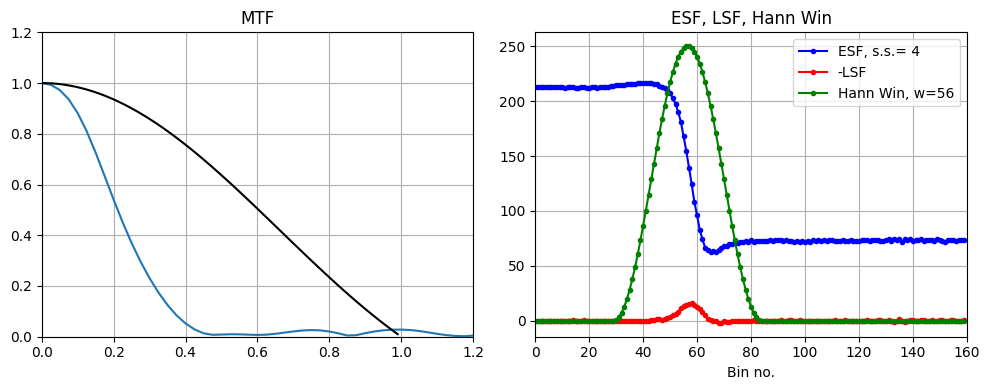

In [22]:
# calculate MTF
def calculate_mtf(lsf, hann_win, idx2, super_sampling, diff_ft):
    # Calculate MTF using the LSF as input and use the supplied window function
    # as filter to remove high frequency noise originating in regions far from
    # the edge

    i1, i2 = idx2
    mtf = np.abs(np.fft.fft(lsf[i1:i2] * hann_win))
    nn = (i2 - i1) // 2
    mtf = mtf[:nn]
    mtf /= mtf[0]  # normalize to zero spatial frequency
    f = np.arange(0, super_sampling / 2, super_sampling / nn / 2)  # spatial frequencies (cy/px)
    # Compensate for finite impulse response of the numerical differentiaion
    # step used to derive the LSF from the ESF
    # NB: This compensation function is incorrect in both ISO 12233:2014
    # and ISO 12233:2017, Annex D
    mtf *= (1 / np.sinc(4 * f / (diff_ft * super_sampling))).clip(0.0, 1.0)
    return np.column_stack((f, mtf))

mtf = calculate_mtf(lsf, hann_win, idx2, s_super_sampling, s_diff_ft)

def plot_mtf_info(mtf, hann_win, idx2, super_sampling):
    i1, i2 = idx2
    nn = (i2 - i1) // 2
    lsf_sign = np.sign(np.mean(lsf[i1:i2] * hann_win))

    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(mtf[:,0], mtf[:,1])
    ax1.grid()
    f = np.arange(0.0, 1.0, 0.01)
    mtf_sinc = np.abs(np.sinc(f))
    ax1.plot(f, mtf_sinc, 'k-', label='sinc')
    ax1.axes.set_ylim(0, 1.2)
    ax1.axes.set_xlim(0, 1.2)
    ax1.set_title("MTF")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(esf[i1:i2], 'b.-', label=f"ESF, s.s.={super_sampling:2d}")
    ax2.plot(lsf_sign * lsf[i1:i2], 'r.-', label=f"{'-' if lsf_sign < 0 else ''}LSF")
    ax2.plot(hann_win * ax2.axes.get_ylim()[1] * 1.1, 'g.-', label=f"Hann Win, w={hann_width:d}")
    ax2.set_xlim(0, 2 * nn)
    # ax2 = ax.twinx()
    # ax2.get_yaxis().set_visible(False)
    ax2.grid()
    ax2.legend(loc='best')
    ax2.set_xlabel('Bin no.')
    ax2.set_title("ESF, LSF, Hann Win")

    plt.tight_layout()
    plt.show()

plot_mtf_info(mtf, hann_win, idx2, s_super_sampling)